RISE, November 2025 
SPDX-License-Identifier: CC-BY-NC-4.0 

| Name | Affiliation | IEEE Member | SSCS Member |
|------|--------------|--------------|--------------|
| Lei Xia | Rice University | Yes | Yes |
| Houbo He | Rice University | Yes | Yes|
| Lawrance Liu | Rice University | No | No |
| Taiyun Chi (Advisor) | Rice University | Yes | Yes |


<span style="font-family:'Times New Roman'; font-size:40px; font-weight:bold;">
Transformer-based Impedance Matching Network Design Automation
</span>


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">
This project is partially from our accepted ASP-DAC 2026 paper "MOTIF-RF: Multi-template On-chip Transformer Synthesis Incorporating Frequency-domain Self-transfer Learning for RFIC Design Automation"
</span>

<span style="font-family:'Times New Roman'; font-size:32px; font-weight:bold;">
Abstract
</span>


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">
This notebook serves a systematic study on developing 1:1 template machine learning (ML) surrogate model (Graph Transformer) and applying it to the inverse design of 1:1 transformer (XFMR) in radio-frequency integrated circuits (RFICs). 
Building on this model, we further develop an inverse design framework based on the covariance matrix adaptation evolutionary strategy (CMA-ES) algorithm. This framework is
validated using multiple impedance-matching tasks, all demonstrating fast convergence and trustworthy performance. These results advance the goal of AI-assisted “specs-to-GDS” automation for RFICs and provide RFIC designers with actionable tools

</span>

<span style="font-family:'Times New Roman'; font-size:32px; font-weight:bold;">
1. Introduction
</span>


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">

The rapid evolution of AI has sparked growing interest in AI-assisted design automation within the RFIC design community. This emerging paradigm promises to significantly enhance design productivity compared with the conventional manual design flow and lower barriers to entry for fresh graduates and less-experienced designers.
<br>

A critical distinction between RFIC and low-frequency analog IC design lies in the extensive use of passive networks. These passive networks perform key circuit functions at RF, such as impedance matching, filtering, power combining or dividing, harmonic shaping, and more. Automating the design of passive networks is therefore a critical step towards realizing a fully automated RFIC design flow.
<br>

As shown in Fig. 1, the process of AI-assisted passive network design automation typically involves two stages. First, ML surrogate models are trained to replace time-consuming EM solvers used in the conventional design flow, enabling rapid yet accurate performance evaluation. Second, inverse design algorithms are applied, generating layouts that meet target specifications. This automated design process is also referred to as “specs to GDS”.
<br>

A typical XFMR consists of two windings—a primary winding and a secondary winding—that are magnetically coupled.In the conventional manual design flow, XFMRs are analyzed using EM simulation tools such as Cadence EMX, Keysight Momentum, or Ansys HFSS. These tools generate S-parameters, which are then imported into circuit simulators to evaluate circuit-level performance metrics including inductance (L), quality factor (Q), impedance (Z), and frequency-dependent loss. However, because EM simulation is computationally intensive, it has become a major productivity bottleneck in RFIC design.
<br>

Although prior works have explored machine-learning surrogate models to predict L and Q, the capability to directly predict broadband S-parameters remains underdeveloped. Since S-parameters are the most fundamental representation of XFMRs—from which nearly all performance characteristics can be derived—our work focuses on constructing surrogate models that directly predict S-parameters. This capability serves as a critical prerequisite for enabling efficient and reliable inverse design of the entire RFIC.


    
<div style="text-align:center;">
  <img src="figures/flowchart.png"
       style="width:900px; border:none; clip-path: inset(2% 2% 2% 2%);">
  <p style="font-family:'Times New Roman'; font-size:16px; margin-top:8px;">
    <b>Fig. 1.</b> “Specs to GDS” for AI-assisted design automation of XFMRs in RFICs, incorporating forward surrogate models and inverse design algorithms.
  </p>
</div>





</span>


<span style="font-family:'Times New Roman'; font-size:32px; font-weight:bold;">
2. About the Notebook
</span>


<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.1 Environment Building
</span>


- [numpy](https://pypi.org/project/numpy/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [scikit-rf (skrf)](https://pypi.org/project/scikit-rf/)
- [scipy](https://pypi.org/project/scipy/)
- [torch](https://pypi.org/project/torch/)
- [torchinfo](https://pypi.org/project/torchinfo/)
- [optuna](https://pypi.org/project/optuna/)
- [cmaes on PyPI](https://pypi.org/project/cmaes/)
- `GT_lib_1x1_code_a_chip` → This is a **custom local module**.  
  Make sure it exists in the same directory as your notebook, or adjust the import path.


[Download Dataset (Google Drive)](https://drive.google.com/drive/folders/1h5SEIrOvKtigSY8v-qnmC2cKBD_1je5n?usp=drive_link)


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">
You can install all dependencies in one command:
</span>

pip install numpy matplotlib scikit-rf scipy torch torchinfo optuna cmaes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from scipy.spatial import distance
from scipy.linalg import eigh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torchinfo import summary
from functools import partial
import GT_lib_1x1_code_a_chip as GTLib
import time
import optuna
import numpy as np
import time
import cmaes

/home/lx27/.conda/envs/code_a_chip_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.2 Data Loading
</span>

<div style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">

Recently developed Graph Transformer (GT) structure excels in capturing topological properties of graph structured data, making them particularly well-suited for circuit modeling.
We adopted an approach similar to [1], which employs Laplacian Summation Positional Encoding (LSPE) to capture graph topological features. In our implementation, each metal segment of the XFMR is represented as a token, characterized by six geometric parameters and an LSPE encoding. These tokens form the input of the GT model, as shown in Fig. 2.

<br>


<div style="text-align:center; width:700px; margin:auto;">
  <div style="overflow:hidden; height:200px;">
    <img src="figures/Transformer_YH.png" style="width:405px; margin-top:0;">
  </div>
</div>

<p style="font-family:'Times New Roman'; font-size:16px; text-align:left; margin-left:0px; margin-top:5px;">
    <b>Fig. 2.</b> XFMR segment embedding
</p>



<br>

[1] D. Kim, J. Park, Y. Oh, and B. Hwang, “Traceformer: S-parameter Prediction Framework for PCB Traces Based on Graph Transformer,” Proc. 61st ACM/ESDA/IEEE Design Autom. Conf. (DAC), p. 1–6, Jun. 2024.

</div>


In [2]:
#define the targeted max frequency
fmax = 200
#define function for loading ind and s-parameters
#"path" is the path for ind of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each ind 
def load_ind_from_path(path, label,length):
    ind_a = []
    ind_b = []
    labels = []
    error = []
    for kk in range(length):
        #load ind
        ind = np.load(path+str(kk)+'.npz')
        result_a = []
        result_b = []
        dst_a = np.zeros(len(ind['a'])-1)
        aj_a = np.zeros((len(ind['a']),len(ind['a'])))
        dst_b = np.zeros(len(ind['b'])-1)
        aj_b = np.zeros((len(ind['b']),len(ind['b'])))
        
        for x in range(len(ind['a'])-1):
            dst = distance.euclidean(ind['a'][x],ind['a'][x+1])
            dst_a[x] = dst
            aj_a[x][x+1] = dst_a[x]
            aj_a[x+1][x] = dst_a[x]
        
        eigenvalues, eigenvectors = eigh(aj_a)
        
        for x in range(len(ind['a'])-1):
            result_a.append([ind['a'][x][0]/100,ind['a'][x][1]/100,ind['a'][x+1][0]/100,ind['a'][x+1][1]/100,dst_a[x]/100,0,np.sum(eigenvectors[x][1]+eigenvectors[x+1][1])])
        ind_a.append(result_a)
        
        for x in range(len(ind['b'])-1):
            dst = distance.euclidean(ind['b'][x],ind['b'][x+1])
            dst_b[x] = dst
            aj_b[x][x+1] = dst_b[x]
            aj_b[x+1][x] = dst_b[x]
        
        eigenvalues, eigenvectors = eigh(aj_b)
        
        for x in range(len(ind['b'])-1):
            result_b.append([ind['b'][x][0]/100,ind['b'][x][1]/100,ind['b'][x+1][0]/100,ind['b'][x+1][1]/100,dst_b[x]/100,0,np.sum(eigenvectors[x][1]+eigenvectors[x+1][1])])
        ind_b.append(result_b)
        #load S-parameters
        #According to symmerty, only S11,S12,S13,S14,S33,S34 are considered
        #Each S-parameter has real and imaginary parts, and hence 12 real values in total.
        results = []
        datafile = label+str(kk)+".s4p"
        spt = rf.Network(datafile)
        step = int(1e9/(spt.f[1]-spt.f[0]))
        for k in range(fmax+1):
            i = k*step
            results.append([spt.s[i][0][0].real,spt.s[i][0][0].imag,
                            spt.s[i][0][1].real,spt.s[i][0][1].imag,
                            spt.s[i][0][2].real,spt.s[i][0][2].imag,
                            spt.s[i][0][3].real,spt.s[i][0][3].imag,
                            spt.s[i][2][2].real,spt.s[i][2][2].imag,
                            spt.s[i][2][3].real,spt.s[i][2][3].imag])     
        sp = np.array(results)
        invalid = False
        if (invalid):
            error.append(kk)
        labels.append(results) 
    return ind_a,ind_b, labels,error

In [3]:
ind_a11 = []
ind_b11 = []
labels11 = []
srf_list = []
logfile = open("./XFMR_2503_1x1/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

length = len(tabular_data)
ind_a, ind_b, labels,error = load_ind_from_path('./XFMR_2503_1x1/SEG/', './XFMR_2503_1x1/SPData/',length)
print(error)
srf = np.load('./XFMR_2503_1x1/srf.npy')

for kk in range(length):
    if kk in error:
        continue  
    #select 1 turn and 1 turn transformers
    if((tabular_data[kk,4]==1) and (tabular_data[kk,5]==1)):
       #b only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded
        for i in range(15):
            ind_a[kk][i][5] = tabular_data[kk][4]
            ind_b[kk][i][5] = tabular_data[kk][5]
        ind_a11.append(np.array(ind_a[kk])[0:5])
        ind_b11.append(np.array(ind_b[kk])[0:5])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(ind_a11))

[]
(1000, 5, 7)


In [4]:
logfile = open("./XFMR_2505_1x1_SameXY/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)
length = 2000
ind_a, ind_b, labels,error = load_ind_from_path('./XFMR_2505_1x1_SameXY/SEG/', './XFMR_2505_1x1_SameXY/SPData/',length)
print(error)
srf = np.load('./XFMR_2505_1x1_SameXY/srf.npy')

for kk in range(length):
    if kk in error:
        continue  
    #select 1 turn and 1 turn transformers
    if((tabular_data[kk,4]==1) and (tabular_data[kk,5]==1)):
       #b only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded
        for i in range(15):
            ind_a[kk][i][5] = tabular_data[kk][4]
            ind_b[kk][i][5] = tabular_data[kk][5]
        ind_a11.append(np.array(ind_a[kk])[0:5])
        ind_b11.append(np.array(ind_b[kk])[0:5])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(ind_a11))

[]
(3000, 5, 7)


In [5]:
logfile = open("./XFMR_2505_1x1_SameXY/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

length = 2000
ind_a, ind_b, labels,error = load_ind_from_path('./XFMR_2505_1x1_SameXY/SEG/', './XFMR_2505_1x1_SameXY/SPData/',length)
print(error)
srf = np.load('./XFMR_2505_1x1_SameXY/srf.npy')

for kk in range(length):
    if kk in error:
        continue  
    #select 1 turn and 1 turn transformers
    if((tabular_data[kk,4]==1) and (tabular_data[kk,5]==1)):
       #b only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded
        for i in range(15):
            ind_a[kk][i][5] = tabular_data[kk][4]
            ind_b[kk][i][5] = tabular_data[kk][5]
        ind_a11.append(np.array(ind_a[kk])[0:5])
        ind_b11.append(np.array(ind_b[kk])[0:5])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(ind_a11))

[]
(5000, 5, 7)


In [6]:
print(np.shape(ind_a11))

(5000, 5, 7)


<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.3 Model Architecture 
</span>

<div style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">

For GT model Connections between adjacent nodes are represented by weighted edges, with edge weights determined by the lengths of the corresponding metal traces. This encoding scheme allows the model to distinguish between different XFMR sizes and shapes based on positional features. As shown in Fig. 3, The input data serve as tokens that are vectorized, upsampled, and passed to the transformer encoder.. This encoder follows the transformer framework [2], where each layer comprises a multi-head attention mechanism and a feedforward neural network. The encoded tokens for all XFMR segments are then concatenated to form a unified representation of the XFMR, followed by an MLP to map the extracted features to the corresponding S-parameters.

<br>


<div style="text-align:center; width:700px; margin:auto;">
  <div style="overflow:hidden; height:200px;">
    <img src="figures/Transformer_YH.png" style="width:410px; margin-top:-210px;">
  </div>
</div>

<p style="font-family:'Times New Roman'; font-size:16px; text-align:left; margin-left:0px; margin-top:5px;">
  <b>Fig. 3.</b> GT-based model architecture
</p>



<br>

[2]A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. N. Gomez, L. u. Kaiser, and I. Polosukhin, “Attention is All you Need,” in Proc. Adv. Neural Inf. Process. Syst. (NeurIPS), vol. 30, 2017.

</div>


In [7]:
d_model = 32
num_heads = 4
dff = 256
num_layers = 2
max_seq_len = 32
height = 7
dropout_rate = 0.1
earning_rate = 1e-4
fdim = 32
epochs = 200
max_len = 5

class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        positions = torch.arange(seq_len).unsqueeze(1).float()  # [seq_len, 1]
        dims = torch.arange(d_model).unsqueeze(0).float()  # [1, d_model]

        angle_rates = 1 / torch.pow(10000.0, (2 * (dims // 2)) / d_model)
        angle_rads = positions * angle_rates

        # Compute sine and cosine
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        # Concatenate sine and cosine
        pos_encoding = torch.cat([sines, cosines], dim=-1)  # [seq_len, d_model]
        self.pos_encoding = pos_encoding.unsqueeze(0)  # [1, seq_len, d_model]

    def forward(self, x):
        return self.pos_encoding[:, :x.size(1), :].to(x.device)


def create_padding_mask(x):
    """
    Compute the padding mask:
    - x: [batch_size, seq_len, height]
    - mask: [batch_size, 1, 1, seq_len]
    """
    summed = torch.sum(torch.abs(x), dim=2)  # [batch_size, seq_len]
    mask = (summed == 0).float()  # 1.0 indicates padding
     # Expand mask to match MultiheadAttention expected shape
    mask = mask[:, None, None, :]  # Shape: [batch_size, 1, 1, seq_len]
    
    # Reshape to [batch_size * num_heads, seq_len, seq_len]
    batch_size, seq_len, height = x.shape
    mask = mask.expand(batch_size, num_heads, seq_len, seq_len)  # [batch_size, num_heads, seq_len, seq_len] 
    # Merge batch_size and num_heads into the first dimension
    mask = mask.reshape(batch_size * num_heads, seq_len, seq_len)
    return mask




def pad_sequence(seq_len, max_len=7):
    length = seq_len.shape[0]
    pad_len = max_len - length
    return torch.cat([seq_len, torch.zeros(pad_len, height)], dim=0)


In [8]:
max_len = max(len(seq) for seq in ind_b11)
max_len = int(max_len) 
print(max_len)

new_a = []
print(ind_a11[0])
for a in ind_a11:
    padded_a = pad_sequence(torch.tensor(a, dtype=torch.float32),max_len)
    new_a.append(padded_a.detach().numpy())
print(np.shape(new_a))
#transformer_encoder.eval()  # Set to evaluation mode
#transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, max_seq_len)
#output = transformer_encoder(torch.stack(new_a))
#print("Output shape:", output.shape)  # [batch_size, seq_len, d_model]
new_b = []
for b in ind_b11:
    padded_b = pad_sequence(torch.tensor(b, dtype=torch.float32),max_len)
    new_b.append(padded_b.detach().numpy())
print(np.shape(new_b))

5
[[-0.165      -1.76       -0.165      -1.005       0.755       1.
   0.03644122]
 [-0.165      -1.005      -0.68179394 -1.005       0.51679394  1.
  -0.08552134]
 [-0.68179394 -1.005      -0.955      -0.68179394  0.42320646  1.
   0.3143857 ]
 [-0.955      -0.68179394 -0.955       0.68179394  1.36358788  1.
   0.00231381]
 [-0.955       0.68179394 -0.68179394  1.005       0.42320646  1.
  -0.3277228 ]]
(5000, 5, 7)
(5000, 5, 7)


In [9]:
class item:
  def __init__(self, a,b,label,srf):
    self.a = a
    self.b = b
    self.label = label
    self.srf = srf
data = []
for i in range(len(ind_a11)):
    data.append(item(new_a[i],new_b[i],labels11[i],srf_list[i]))

np.random.shuffle(data)

In [10]:
length = len(ind_a11)
split1 = int(0.6*length)
split2 = int(0.8*length)
data_train = data[0:split1]
data_valid = data[split1:split2]
data_test = data[split2:]

In [11]:
#Separate the training, validation and test datasets 
train_a = []
train_labels = []
train_b = []
train_srf = []
valid_a = []
valid_labels = []
valid_b = []
valid_srf = []
test_a = []
test_labels = []
test_b = []
test_srf = []

#The targeted frequency span up to fmax, with 1GHz step
s_max = np.zeros((fmax,12))
s_min = np.zeros((fmax,12))
srange = np.zeros((fmax,12))


for i in range(len(data_train)):
    train_a.append(data_train[i].a)
    train_b.append(data_train[i].b)
    train_labels.append(data_train[i].label)
    train_srf.append(data_train[i].srf)
x_train_a = np.array(train_a) 
x_train_b = np.array(train_b)
x_train_srf = np.array(train_srf)
y_train_encoded = np.array(train_labels)[:,1:fmax+1,:]


for i in range(len(data_valid)):
    valid_a.append(data_valid[i].a)
    valid_b.append(data_valid[i].b)
    valid_labels.append(data_valid[i].label)
    valid_srf.append(data_valid[i].srf)
x_valid_a = np.array(valid_a) 
x_valid_b = np.array(valid_b)
x_valid_srf = np.array(valid_srf)
y_valid_encoded = np.array(valid_labels)[:,1:fmax+1,:]


for i in range(len(data_test)):
    test_a.append(data_test[i].a)
    test_b.append(data_test[i].b)
    test_labels.append(data_test[i].label)
    test_srf.append(data_test[i].srf)
x_test_a = np.array(test_a) 
x_test_b = np.array(test_b)
x_test_srf = np.array(test_srf)
y_test_encoded = np.array(test_labels)[:,1:fmax+1,:]

#normalize the s-parameters for each frequency point
for z in range(fmax):
    for i in range(12):
        s_max[z,i] = max(max(y_train_encoded[:,z,i]),max(y_valid_encoded[:,z,i]),max(y_test_encoded[:,z,i]))
        s_min[z,i] = min(min(y_train_encoded[:,z,i]),min(y_valid_encoded[:,z,i]),min(y_test_encoded[:,z,i]))
        srange[z,i] = s_max[z,i]-s_min[z,i]
    
    for i in range(12):
        y_train_encoded[:,z,i] = 2*(y_train_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

    for i in range(12):
        y_valid_encoded[:,z,i] = 2*(y_valid_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1
    
    for i in range(12):
        y_test_encoded[:,z,i] = 2*(y_test_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

np.savez("./s_parameters_code_a_chip.npz", s_max=s_max, s_min=s_min, srange=srange)

In [12]:
print(y_test_encoded.shape)

(1000, 200, 12)


In [13]:
def custom_loss(y_true, y_pred):
    Lf = torch.sqrt(torch.mean((y_true - y_pred) ** 2, dim=1))  # Compute RMSE across feature axis
    return torch.log(torch.mean(Lf))  # Compute log of mean RMSE
    #return (torch.mean(Lf))

In [14]:
def get_activation(activation_str):
    """Map string to activation function."""
    if activation_str.lower() == "relu":
        return F.relu
    elif activation_str.lower() == "gelu":
        return F.gelu
    # Add more activations if needed
    else:
        raise ValueError(f"Unsupported activation: {activation_str}")

class TransformerEncoderBlock(nn.Module):
    """
    One Transformer encoder block, matching the structure of:
      1) Multi-head self-attention (with dropout)
      2) Feed-forward network (two linear layers + activation + dropout)
      3) LayerNorm + residual connections
      4) Optional "pre-norm" (norm_first=True) vs "post-norm" (norm_first=False)
    """
    def __init__(
        self,
        hidden_size,
        num_attention_heads,
        intermediate_size,
        activation="relu",
        dropout_rate=0.0,
        attention_dropout_rate=0.0,
        use_bias=False,
        norm_first=True,
        norm_epsilon=1e-6,
        intermediate_dropout=0.0
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.dropout_rate = dropout_rate
        self.attention_dropout_rate = attention_dropout_rate
        self.use_bias = use_bias
        self.norm_first = norm_first
        self.norm_epsilon = norm_epsilon
        self.intermediate_dropout = intermediate_dropout

        # ---- Self-Attention ----
        # nn.MultiheadAttention expects shape: [seq_len, batch_size, embed_dim]
        # bias = `use_bias` is not directly exposed in nn.MultiheadAttention;
        # PyTorch always learns a bias in the projection layers. If you want
        # to remove bias, you must create a custom multi-head attention layer.
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=attention_dropout_rate,
            batch_first=False,  # We'll reshape manually
            # PyTorch multi-head attention includes biases by default.
            # For a strictly "no-bias" version, you'd need a custom approach.
        )

        self.attention_dropout = nn.Dropout(dropout_rate)
        self.attention_layer_norm = nn.LayerNorm(hidden_size, eps=norm_epsilon)

        # ---- Feed-Forward Network (FFN) ----
        self.intermediate_dense = nn.Linear(hidden_size, intermediate_size, bias=use_bias)
        self.intermediate_act_fn = get_activation(activation)
        self.intermediate_dropout_layer = nn.Dropout(intermediate_dropout)

        self.output_dense = nn.Linear(intermediate_size, hidden_size, bias=use_bias)
        self.output_dropout = nn.Dropout(dropout_rate)
        self.output_layer_norm = nn.LayerNorm(hidden_size, eps=norm_epsilon)

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
          hidden_states: Tensor of shape [batch_size, seq_len, hidden_size].
          attention_mask: Optional tensor for attention, expected shape
              [batch_size, seq_len, seq_len] with 0 for valid positions and
              -inf (or large negative) for masked positions, or a boolean mask.
              This may need to be adapted depending on how you've constructed
              your mask. 
        Returns:
          hidden_states: Tensor of shape [batch_size, seq_len, hidden_size].
        """

        # --- Self-Attention block ---
        # If norm_first, we layer-norm before attention; otherwise after
        residual = hidden_states
        if self.norm_first:
            hidden_states = self.attention_layer_norm(hidden_states)

        # Reshape hidden_states from [batch, seq, dim] to [seq, batch, dim]
        hidden_states_t = hidden_states.transpose(0, 1)

        # Convert mask if needed: PyTorch expects shape [seq_len, seq_len] or 
        # [batch_size * num_heads, seq_len, seq_len]. 
        # A simple approach is to expand so shape [batch, 1, seq, seq].
        # Then internally PyTorch may broadcast it properly, or you
        # can pass `attn_mask=some_mask` that is [seq, seq]. 
        # Here is an example that transforms the user’s [batch, seq, seq] 
        # into a float mask with -inf in invalid positions:
        if attention_mask is not None:
            # Suppose attention_mask=1 for valid, 0 for invalid, or the other way around.
            # You may need to invert it, depending on how your mask is built.
            # Here we assume "1 = keep, 0 = mask out".
            attn_mask_pytorch = (1.0 - attention_mask) * -1e9
            # Expand dims if needed to [batch, 1, seq, seq], then flatten
            # heads.  Alternatively, you can let PyTorch broadcast the shape.
            # We’ll do a direct approach below:
            attn_mask_pytorch = attn_mask_pytorch.unsqueeze(1)  # [batch, 1, seq, seq]
        else:
            attn_mask_pytorch = None

        # Apply multi-head attention:
        attn_output, _ = self.self_attention(
            hidden_states_t,   # query
            hidden_states_t,   # key
            hidden_states_t,   # value
            attn_mask=attn_mask_pytorch,
        )

        # Transpose back to [batch, seq, dim]
        attn_output = attn_output.transpose(0, 1)

        attn_output = self.attention_dropout(attn_output)
        # Residual connection
        hidden_states = residual + attn_output

        if not self.norm_first:
            hidden_states = self.attention_layer_norm(hidden_states)

        # --- Feed Forward block ---
        residual = hidden_states
        if self.norm_first:
            hidden_states = self.output_layer_norm(hidden_states)

        # Intermediate (expand) + activation
        hidden_states = self.intermediate_dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        hidden_states = self.intermediate_dropout_layer(hidden_states)

        # Project back to hidden_size
        hidden_states = self.output_dense(hidden_states)
        hidden_states = self.output_dropout(hidden_states)

        # Residual connection
        hidden_states = residual + hidden_states

        if not self.norm_first:
            hidden_states = self.output_layer_norm(hidden_states)

        return hidden_states


class TransformerEncoder(nn.Module):
    """
    Stacks N TransformerEncoderBlock layers and applies a final layer norm
    (to match the original Keras code which has 'output_normalization').
    """
    def __init__(
        self,
        num_layers=6,
        num_attention_heads=8,
        intermediate_size=2048,
        activation="relu",
        dropout_rate=0.0,
        attention_dropout_rate=0.0,
        use_bias=False,
        norm_first=True,
        norm_epsilon=1e-6,
        intermediate_dropout=0.0,
        hidden_size=None,
    ):
        """
        Args:
          num_layers: Number of encoder layers.
          num_attention_heads: Number of attention heads.
          intermediate_size: Dim of the FFN's hidden layer.
          activation: Activation for the intermediate (FFN) layer.
          dropout_rate: Dropout probability for the output of each sub-layer.
          attention_dropout_rate: Dropout probability for the attention scores.
          use_bias: Whether linear layers use bias.
          norm_first: If True, apply layer norm before each sub-block.
          norm_epsilon: Epsilon for layer norm.
          intermediate_dropout: Dropout within the feed-forward 'intermediate' layers.
          hidden_size: The input/output hidden size. If None, derive from input.
        """
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.attention_dropout_rate = attention_dropout_rate
        self.use_bias = use_bias
        self.norm_first = norm_first
        self.norm_epsilon = norm_epsilon
        self.intermediate_dropout = intermediate_dropout

        # You can either require hidden_size to be passed explicitly,
        # or you can infer it at runtime (by passing the first batch through).
        if hidden_size is None:
            raise ValueError(
                "You must specify 'hidden_size' (the input feature dimension)."
            )

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(
                hidden_size=hidden_size,
                num_attention_heads=self.num_attention_heads,
                intermediate_size=self.intermediate_size,
                activation=self.activation,
                dropout_rate=self.dropout_rate,
                attention_dropout_rate=self.attention_dropout_rate,
                use_bias=self.use_bias,
                norm_first=self.norm_first,
                norm_epsilon=self.norm_epsilon,
                intermediate_dropout=self.intermediate_dropout,
            ) for _ in range(self.num_layers)
        ])

        self.output_normalization = nn.LayerNorm(hidden_size, eps=self.norm_epsilon)

    def forward(self, encoder_inputs, attention_mask=None):
        """
        Args:
          encoder_inputs: shape [batch_size, seq_len, hidden_size].
          attention_mask: shape [batch_size, seq_len, seq_len] or None.
        Returns:
          output shape [batch_size, seq_len, hidden_size].
        """
        hidden_states = encoder_inputs

        # Pass through each TransformerEncoderBlock
        for i, layer in enumerate(self.encoder_layers):
            hidden_states = layer(hidden_states, attention_mask=attention_mask)

        # Final layer normalization (as in Keras code)
        output_tensor = self.output_normalization(hidden_states)
        return output_tensor



In [15]:

#################################
# Main Model
#################################
class CustomModel(nn.Module):
    def __init__(self, transformer_encoder, fmax):
        super(CustomModel, self).__init__()
        self.transformer_encoder = transformer_encoder  # Use the pre-defined transformer model
        self.fcl1 = nn.Linear(7, fdim)
        self.fcl2 = nn.Linear(7, fdim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(max_len*fdim*2, 512)  # Adjust input shape after concatenation 448*512
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.out = nn.Linear(512, fmax * 12)
        self.reshape = lambda x: x.view(-1, fmax, 12)  # Equivalent to `Reshape((fmax,12))` in Keras
    def forward(self, inp1, inp2):
        l1 = self.fcl1(inp1)
        l2 = self.fcl2(inp2)
        l1 = self.transformer_encoder(l1)
        l2 = self.transformer_encoder(l2)

        out = torch.cat((l1, l2), dim=1)  # Equivalent to `Concatenate()([l1, l2])`
        out = self.flatten(out) #shape [8 2048]
     #   print("1:", out.shape)  
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
      #  print("2:", out.shape)  
        out = torch.tanh(self.out(out))  # Equivalent to `Dense(fmax*12, activation='tanh')`
        out = self.reshape(out)
       # print("3:", out.shape)  
        return out


<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.4 Model Training
</span>

In [16]:
# Define Hyperparameters
learning_rate = 1e-4

epochs = 500
# Check if CUDA is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Initialize PyTorch model and move to device
model = CustomModel(TransformerEncoder(intermediate_size=512,hidden_size=fdim), fmax)  .to(device)  # Move model to GPU
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
def lr_lambda(epoch):
    return 0.95 ** (epoch / 20)  

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
# Loss function
loss_function = custom_loss

# Metric for MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

# Training loop
def train_model(model, optimizer, scheduler,loss_function, num_epochs, dataloader):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_mae = 0.0

        for batch in dataloader:
            inp1, inp2, y_true = batch  # Unpack inputs and true labels

            # Move data to GPU
            inp1 = inp1.to(device)
            inp2 = inp2.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()  # Clear gradients
            y_pred = model(inp1,inp2)  # Forward pass

            # Compute loss
            loss = loss_function(y_true, y_pred)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            # Metrics
            batch_mae = mae(y_true, y_pred)
            running_loss += loss.item()
            running_mae += batch_mae.item()

        # Update learning rate at the end of each epoch
        scheduler.step()

        # Average loss and metrics for the epoch
        avg_loss = running_loss / len(dataloader)
        avg_mae = running_mae / len(dataloader)
        if epoch%20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}")

batch_size = 32

xx = 0
# Convert data to PyTorch tensors and move them to float32
yout = torch.from_numpy(y_train_encoded).type(torch.float32)
x1 = torch.from_numpy(x_train_a).type(torch.float32)  # Example image input
x2 = torch.from_numpy(x_train_b).type(torch.float32)  # Example auxiliary input

# Create dataset and DataLoader
dataset = torch.utils.data.TensorDataset(x1, x2, yout)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Move tensors to device
x1 = x1.to(device)
x2 = x2.to(device)
yout = yout.to(device)

# Train the model
train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

Using device: cuda:0
Epoch [1/500], Loss: -1.0569, MAE: 0.2935
Epoch [21/500], Loss: -2.0746, MAE: 0.1011
Epoch [41/500], Loss: -2.4207, MAE: 0.0708
Epoch [61/500], Loss: -2.6288, MAE: 0.0574
Epoch [81/500], Loss: -2.8148, MAE: 0.0475
Epoch [101/500], Loss: -2.9789, MAE: 0.0402
Epoch [121/500], Loss: -3.0892, MAE: 0.0359
Epoch [141/500], Loss: -3.1539, MAE: 0.0336
Epoch [161/500], Loss: -3.2862, MAE: 0.0292
Epoch [181/500], Loss: -3.3126, MAE: 0.0286
Epoch [201/500], Loss: -3.3725, MAE: 0.0269
Epoch [221/500], Loss: -3.3993, MAE: 0.0262
Epoch [241/500], Loss: -3.4850, MAE: 0.0240
Epoch [261/500], Loss: -3.5021, MAE: 0.0236
Epoch [281/500], Loss: -3.6079, MAE: 0.0211
Epoch [301/500], Loss: -3.6274, MAE: 0.0207
Epoch [321/500], Loss: -3.6440, MAE: 0.0203
Epoch [341/500], Loss: -3.6916, MAE: 0.0194
Epoch [361/500], Loss: -3.7319, MAE: 0.0186
Epoch [381/500], Loss: -3.7733, MAE: 0.0178
Epoch [401/500], Loss: -3.8234, MAE: 0.0168
Epoch [421/500], Loss: -3.7736, MAE: 0.0179
Epoch [441/500], 

In [17]:
torch.save(model.state_dict(), './models/GT_model/'+str(xx) + '.pth')

In [18]:
summary(model, input_size=[(1, 5, 7),(1,5,7)])

Layer (type:depth-idx)                        Output Shape              Param #
CustomModel                                   [1, 200, 12]              --
├─Linear: 1-1                                 [1, 5, 32]                256
├─Linear: 1-2                                 [1, 5, 32]                256
├─TransformerEncoder: 1-3                     [1, 5, 32]                --
│    └─ModuleList: 2-3                        --                        (recursive)
│    │    └─TransformerEncoderBlock: 3-1      [1, 5, 32]                37,120
│    │    └─TransformerEncoderBlock: 3-2      [1, 5, 32]                37,120
│    │    └─TransformerEncoderBlock: 3-3      [1, 5, 32]                37,120
│    │    └─TransformerEncoderBlock: 3-4      [1, 5, 32]                37,120
│    │    └─TransformerEncoderBlock: 3-5      [1, 5, 32]                37,120
│    │    └─TransformerEncoderBlock: 3-6      [1, 5, 32]                37,120
│    └─LayerNorm: 2-2                         [1, 5, 32]    

In [19]:
def prediction(ax):
    # Initialize prediction arrays
    test_prediction = np.zeros((len(x_test_a), fmax, 12))

    # Convert test data to tensor
    xtest_a = torch.from_numpy(x_test_a).float().to(device)
    xtest_b = torch.from_numpy(x_test_b).float().to(device)

    # Load model
    model.load_state_dict(torch.load('./models/GT_model/0.pth'))

    # Run prediction
    pred = model(xtest_a, xtest_b).cpu().detach().numpy()  # shape: (N, fmax, 12)
    test_prediction[:] = pred

    # Compute MAE per frequency and overall mean
    mae_all = np.zeros((fmax, 12))
    mae_mean = np.zeros(fmax)

    for z in range(fmax): 
        for i in range(12):
            mae_all[z][i] = np.mean(np.abs(test_prediction[:, z, i] - y_test_encoded[:, z, i])) * 0.5 * srange[z, i]
        mae_mean[z] = np.mean(mae_all[z])

    # Plot MAE over frequency
    ax.plot(range(fmax), mae_mean)
    ax.set_xlabel('Frequency / GHz')
    ax.set_ylabel('Average S-parameter MAE')

    # Print metrics
    print("Mean MAE =", np.mean(mae_mean))
    print("R² =", R_squared(torch.from_numpy(y_test_encoded),
                             torch.from_numpy(test_prediction)))

    return np.mean(mae_mean)

    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

In [20]:
def prediction_srf(ax):
    test_prediction = np.zeros((len(x_test_a), fmax, 12))

    xtest_a = torch.from_numpy(x_test_a).type(torch.float32).to(device)
    xtest_b = torch.from_numpy(x_test_b).type(torch.float32).to(device)

    model.load_state_dict(torch.load('./models/GT_model/0.pth'))
    test_prediction[:] = model(xtest_a, xtest_b).cpu().detach().numpy()

    n_srf = 100
    srf_mae_all = np.zeros((n_srf, 12))
    srf_mae = np.zeros(n_srf)

    for z in range(n_srf):
        for sample in range(len(x_test_a)):
            freq_temp = int(min(fmax - 1, z * test_srf[sample] * 2 / n_srf))
            for i in range(12):
                srf_mae_all[z][i] += (abs(test_prediction[sample, freq_temp, i]
                                          - y_test_encoded[sample, freq_temp, i])) * 0.5 * srange[z, i]
        srf_mae_all[z] = srf_mae_all[z] / len(x_test_a)
        srf_mae[z] = np.mean(srf_mae_all[z][:])

    ax.plot((2 / n_srf) * np.ones(n_srf) * range(n_srf), srf_mae)
    print(np.mean(srf_mae))
    print(R_squared(torch.from_numpy(y_test_encoded), torch.from_numpy(test_prediction)))
    return np.mean(srf_mae)

    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.5 Mean Absolute Error (MAE) over Frequency between Predicted S-parameters and Simulation Ground Truth.
</span>

Mean MAE = 0.014680872337791927
R² = tensor(0.9865, dtype=torch.float64)
0.009514395519261849
tensor(0.9865, dtype=torch.float64)


Text(0, 0.5, 'Average S-parameter mae')

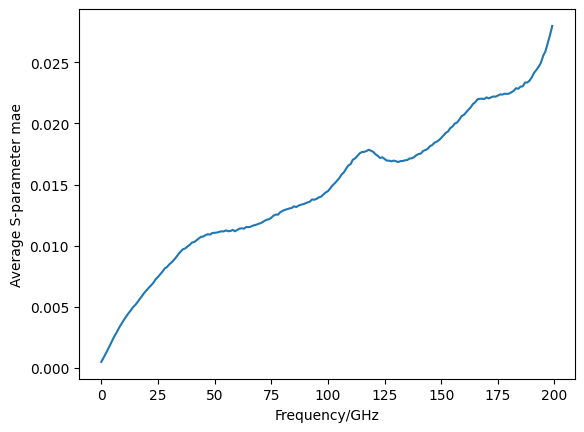

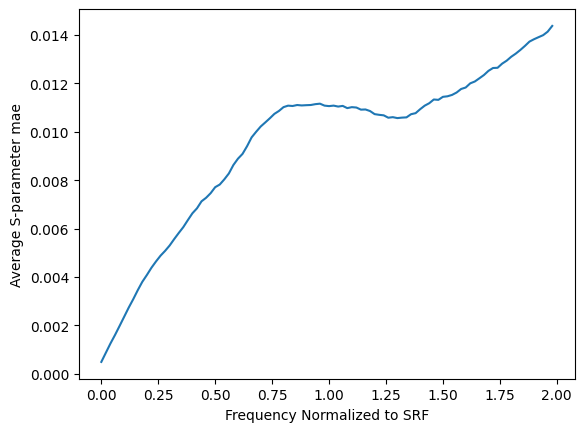

In [21]:
epochs = 200
iteration = 5
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
mae_trend = np.zeros(iteration)
mae_trend=prediction(ax1)
prediction_srf(ax2)
ax1.set_xlabel('Frequency/GHz')
ax1.set_ylabel('Average S-parameter mae')
ax2.set_xlabel('Frequency Normalized to SRF')
ax2.set_ylabel('Average S-parameter mae')

<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.6 Performance of Other Models on 1:1 XFMR
</span>

<div style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">
We also evaluated different models on the 1:1 XFMR dataset. It can be observed that the GT model achieves approximately a 30% reduction in MAE compared with other models.

**Table 1. Evaluation on the 1:1 XFMR Dataset**

| **Trained Model** | **MLP** | **CNN** | **UNet** | **GT** |
|---|---:|---:|---:|---:|
| Params | 2.02M | 2.93M | 2.03M | 1.95M |
| R<sup>2</sup> | 0.978 | 0.972 | 0.978 | 0.987 |
| MAE<sub>avg,200G</sub> | 0.0214 | 0.0252 | 0.0222 | 0.0139 |
| MAE<sub>avg,2SRF</sub> | 0.0135 | 0.0151 | 0.0144 | 0.0103 |
</div>


<span style="font-family:'Times New Roman'; font-size:26px; font-weight:bold;">
2.7 Inverse Design
</span>

<div style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">
In this work, we focus on the differential-mode operation of XFMRs, as RFICs usually employ differential circuits to enable robustness against common-mode noise (e.g. noise on supply and ground lines). The design objective is to determine the optimal XFMR layout based on the target source impedance $Z_{01}$, load impedance $Z_{02}$, center frequency $f_{c}$, and bandwidth Ω. To evaluate inverse design quality, we define a custom cost function, as
$$
J_S = w_0A + \sum_{f \in \Omega} w_f \Bigg(w_1|\Gamma_{in}| + w_2(1 - |L|)\Bigg)
$$
<br>

Here, $w_{0}$, $w_{1}$, $w_{2}$ are weights assigned to the layout area (A), input reflection coefficient ($Γ_{in}$), and loss (L), respectively. Γin and L can be readily derived from the S-parameters. In practice, a well-designed impedance-matching circuit should present |$Γ_{in}$| < –10 dB, and L should be as close to 0 dB as possible. $w_{f}$ is a frequency-domain window function, defined and illustrated in Fig. 4(a). By adjusting the window index ρ, the bandwidth profile of the cost function can be shaped to accommodate different bandwidth specifications. Additionally, we incorporate shunt capacitors into the XFMR based matching network [Fig. 4(b)] to compensate reactive components and achieve broadband impedance transformation, a common practice in RFIC designs
<br> 
<br>

<div style="text-align:center;">
  <img src="figures/wf_cascade.png"
       style="width:900px; border:none; clip-path: inset(2% 2% 2% 2%);">
  <p style="font-family:'Times New Roman'; font-size:16px; margin-top:8px;">
    <b>Fig. 4.</b> (a) Window function $w_{f}$ . (b) Adding shunt capacitors for matching.
  </p>
</div>
<br> 
We adopt the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) algorithm [3] in this work, which dynamic namically adjusts both the covariance matrix and step size during optimization. In repeated experiments, using 4 CPU cores, our framework consistently converged to near-optimal cost values within three minutes

<br>
<br>
[3]N. Hansen and A. Ostermeier, “Adapting Arbitrary Normal Mutation Distributions in Evolution Strategies: The Covariance Matrix Adapta-tion,” in Proc. IEEE Int. Conf. Evol. Comput. (ICEC), 1996, pp. 312–
317.
</div>

In [22]:
def batched_objective(params,imp1,imp2,central_frequency,area_penalty,window,s_max,s_min,Roll_off_factor,model_pre):
    global time_seq, start_time, accumulated_time,freqs,weights,cap1,cap2
    cap1 = 0
    cap2 = 0
    time_seq.append(time.time()-start_time+accumulated_time)
    freqs, weights = GTLib.CreateFqWt(central_frequency,window,Roll_off_factor)#central frequency[0,150], window[10%,70%], roll off factor
    return GTLib.fun_batch(params[:,:-2],freqs,weights,imp1,imp2,params[:,-2],params[:,-1],model_pre,s_max,s_min,device,area_penalty)
    
def Inverse_Design_CMA(model_pre,imp1,imp2,central_frequency,area_penalty,window,s_max,s_min,Roll_off_factor):
    
    global time_seq, start_time, accumulated_time,freqs,weights,cap1,cap2
    time_seq = []
    res_seq = []
    time_cmaes = []
    res_cmaes = []
    accumulated_time = 0
    accumulated_time_cmaes = 0
    accumulated_time = accumulated_time_cmaes
    time_seq = time_cmaes.copy()
    res_seq = res_cmaes.copy()
    batch_size = 100
    start_time = time.time()
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler())
    for iter in range(100):
        # create batch
        trial_numbers = []
        x_batch = []
        for _ in range(batch_size):
            trial = study.ask()
            trial_numbers.append(trial.number)
            temp = []
            temp.append(trial.suggest_int('ra',0,150))
            temp.append(trial.suggest_int('rb',0,150))
            temp.append(trial.suggest_int('wida',3,16))
            temp.append(trial.suggest_int('widb',3,16))
            temp.append(trial.suggest_int('gapa',2,32))
            temp.append(trial.suggest_int('gapb',2,32))
            temp.append(trial.suggest_int('opena',5,150))
            temp.append(trial.suggest_int('openb',5,150))
            temp.append(trial.suggest_int('dist',0,150))
            temp.append(trial.suggest_float('ratio',0.4,1))
            temp.append(trial.suggest_int('cap1',0,120))
            temp.append(trial.suggest_int('cap2',0,120))
            x_batch.append(temp)

        objectives = batched_objective(np.array(x_batch),imp1,imp2,central_frequency,area_penalty,window,s_max,s_min,Roll_off_factor,model_pre)
        for trial_number, objective in zip(trial_numbers, objectives):
            study.tell(trial_number, objective)
        res_seq.append(study.best_value)
        print(f'Iteration {iter}, Best Value: {study.best_value}, Best Params: {study.best_params}')
    best_params = study.best_params
    accumulated_time = time_seq[-1]
    accumulated_time_cmaes = accumulated_time
    time_cmaes = time_seq.copy()
    res_cmaes = res_seq.copy()
    print("Best Hyper-params", best_params)
    print(study.best_value)
    test_params = list(best_params.values())
    cap1 = test_params[-2]
    cap2 = test_params[-1]
    test_params = test_params[:-2]
    J,s_general,area = GTLib.fun_PRINT(test_params,freqs,weights,imp1,imp2,cap1,cap2,model_pre,s_max,s_min,device,area_penalty)
    print('area=',area)
    return J,s_general,area,study.best_params,time_cmaes,res_cmaes

In [23]:
data = np.load("./s_parameters_code_a_chip.npz")
s_max = data["s_max"]
s_min = data["s_min"]
srange = data["srange"]
Imp1 = 50
Imp2 = 50
Central_Frequency = 130
Area_penalty = 1e-5
Window = 20
Roll_off_factor = 0.4
model.load_state_dict(torch.load('./models/GT_model/'+str(xx)+'.pth'))
J, s_general, area, best_params,time_cmaes,res_cmaes = Inverse_Design_CMA(model, Imp1, Imp2, Central_Frequency, Area_penalty, Window, s_max, s_min, Roll_off_factor)

[I 2025-10-31 12:25:24,320] A new study created in memory with name: no-name-961e3f6a-1a44-4517-a568-a00a0cd26892


Iteration 0, Best Value: 2.0293053276053126, Best Params: {'ra': 57, 'rb': 67, 'wida': 6, 'widb': 11, 'gapa': 7, 'gapb': 14, 'opena': 60, 'openb': 42, 'dist': 59, 'ratio': 0.6993111069396973, 'cap1': 107, 'cap2': 54}
Iteration 1, Best Value: 1.8159846831676152, Best Params: {'ra': 91, 'rb': 89, 'wida': 9, 'widb': 13, 'gapa': 8, 'gapb': 13, 'opena': 62, 'openb': 55, 'dist': 27, 'ratio': 0.6218039862288027, 'cap1': 48, 'cap2': 10}
Iteration 2, Best Value: 1.7534289212685334, Best Params: {'ra': 95, 'rb': 107, 'wida': 11, 'widb': 16, 'gapa': 17, 'gapb': 16, 'opena': 61, 'openb': 56, 'dist': 57, 'ratio': 0.558043038445975, 'cap1': 32, 'cap2': 24}
Iteration 3, Best Value: 1.7534289212685334, Best Params: {'ra': 95, 'rb': 107, 'wida': 11, 'widb': 16, 'gapa': 17, 'gapb': 16, 'opena': 61, 'openb': 56, 'dist': 57, 'ratio': 0.558043038445975, 'cap1': 32, 'cap2': 24}
Iteration 4, Best Value: 1.7534289212685334, Best Params: {'ra': 95, 'rb': 107, 'wida': 11, 'widb': 16, 'gapa': 17, 'gapb': 16, 'op

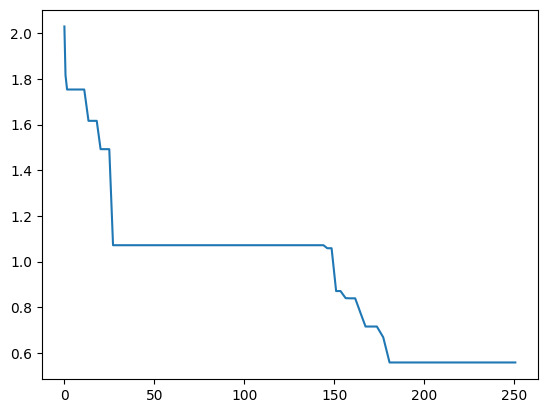

In [24]:
plt.plot(time_cmaes,res_cmaes)

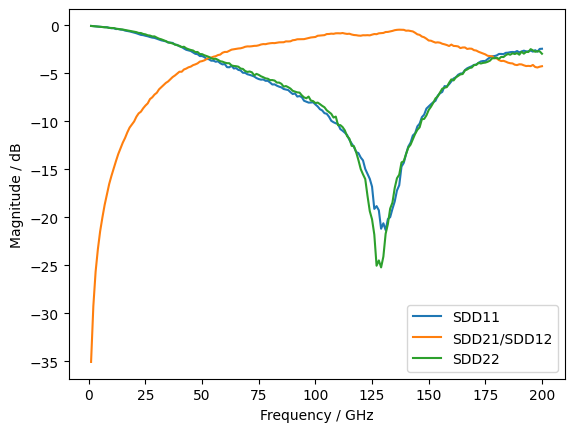

In [25]:
plt.plot(range(1,fmax+1),20*np.log10(np.abs(s_general[:,0,0])),label="SDD11")
plt.plot(range(1,fmax+1),20*np.log10(np.abs(s_general[:,1,0])),label="SDD21/SDD12")
plt.plot(range(1,fmax+1),20*np.log10(np.abs(s_general[:,1,1])),label="SDD22")
plt.legend()
plt.xlabel('Frequency / GHz')
plt.ylabel('Magnitude / dB')
plt.show()


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">

s_sim is obtained from electromagnetic (EM) simulations using EMX stored as 0.s4p
</span>

In [35]:

geometry_values = values[:10]
cap1, cap2 = values[10], values[11]
z1, z2 = Imp1, Imp2
freqs, weights = GTLib.CreateFqWt(Central_Frequency, Window, Roll_off_factor)
best_value,s_sim = GTLib.fun_manual(geometry_values,freqs,weights,Area_penalty,z1, z2, int(cap1), int(cap2), fmax=200)


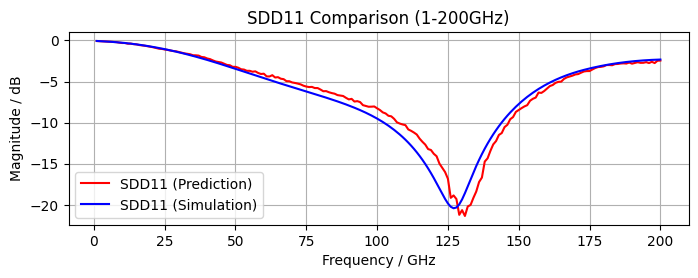

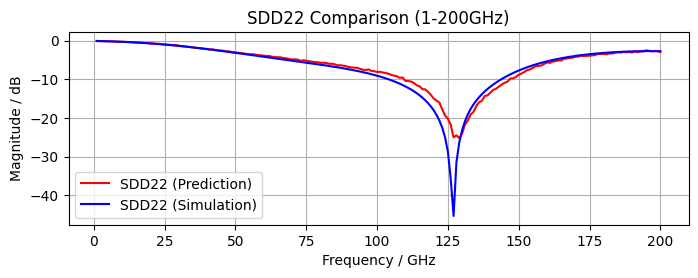

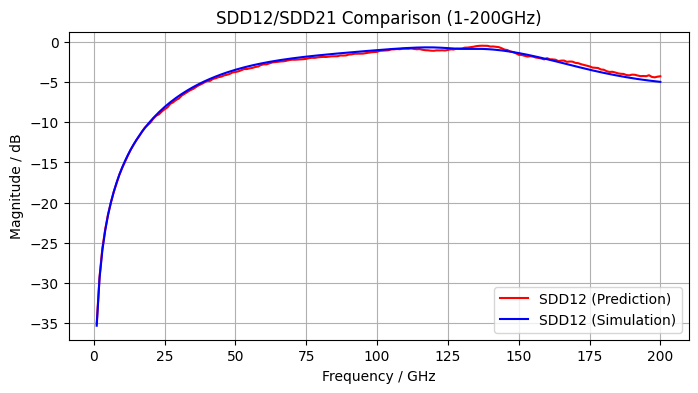

In [36]:
fc = 130
window = 10
f_start = 1
f_end = 200

idx_start = f_start-1
idx_end = f_end

freqs_range = range(f_start, f_end+1)
s_general_range = s_general[idx_start:idx_end, :, :]
s_sim_range = s_sim[idx_start:idx_end, :, :]

# SDD11 comparison
plt.figure(figsize=(8, 2.5), dpi=100)
plt.plot(freqs_range, 20*np.log10(np.abs(s_general_range[:,0,0])), label="SDD11 (Prediction)", color='red')
plt.plot(freqs_range, 20*np.log10(np.abs(s_sim_range[:,0,0])), label="SDD11 (Simulation)", color='blue')
plt.xlabel('Frequency / GHz')
plt.ylabel('Magnitude / dB')
plt.title(f'SDD11 Comparison ({f_start}-{f_end}GHz)')
plt.legend()
plt.grid(True)
plt.show()

# SDD22 comparison
plt.figure(figsize=(8, 2.5), dpi=100)
plt.plot(freqs_range, 20*np.log10(np.abs(s_general_range[:,1,1])), label="SDD22 (Prediction)", color='red')
plt.plot(freqs_range, 20*np.log10(np.abs(s_sim_range[:,1,1])), label="SDD22 (Simulation)", color='blue')
plt.xlabel('Frequency / GHz')
plt.ylabel('Magnitude / dB')
plt.title(f'SDD22 Comparison ({f_start}-{f_end}GHz)')
plt.legend()
plt.grid(True)
plt.show()

# SDD12 comparison
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(freqs_range, 20*np.log10(np.abs(s_general_range[:,0,1])), label="SDD12 (Prediction)", color='red')
plt.plot(freqs_range, 20*np.log10(np.abs(s_sim_range[:,0,1])), label="SDD12 (Simulation)", color='blue')
plt.xlabel('Frequency / GHz')
plt.ylabel('Magnitude / dB')
plt.title(f'SDD12/SDD21 Comparison ({f_start}-{f_end}GHz)')
plt.legend()
plt.grid(True)
plt.show()


<span style="font-family:'Times New Roman'; font-size:32px; font-weight:bold;">
3. Other Inverse Design Examples
</span>


<span style="font-family:'Times New Roman'; font-size:18px; line-height:1.6;">

We illustrate the inverse design of XFMRs by assigning an impedance-matching task as our design target, as impedance matching is a foundational requirement in almost all RFIC designs. The following sub-sections present our cost
function, model accuracy requirement, and several exemplar demonstrations.
    
<div style="text-align:center;">
  <img src="figures/opt_tasks.png"
       style="width:900px; border:none; clip-path: inset(2% 2% 2% 2%);">
  <p style="font-family:'Times New Roman'; font-size:16px; margin-top:8px;">
    <b>Fig. 5.</b> Four inverse design examples using XFMRs for impedance matching, each with a different XFMR topology and a different application scenario.
  </p>
</div>





</span>
